In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# 1. Đọc dữ liệu từ file CSV
data = pd.read_csv('../../data/ai4i2020.csv')

# 2. Chọn các cột đặc trưng và nhãn
features = data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
labels = data['Machine failure']  # Nhãn bất thường

# 3. Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 4. Chọn dữ liệu bình thường (Machine failure = 0) để huấn luyện
X_train = scaled_features[labels == 0][:8000]  # Huấn luyện với 8000 dòng bình thường
test_data = data.sample(n=5000, random_state=42)  # 5000 dòng ngẫu nhiên cho kiểm tra
X_test = scaler.transform(test_data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']))
y_test = test_data['Machine failure'].values  # Nhãn thực tế cho kiểm tra

# Chuyển đổi sang Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 5. Định nghĩa Generator và Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 6. Khởi tạo Generator, Discriminator, và optimizer
input_dim = X_train.shape[1]
latent_dim = 2  # Kích thước không gian tiềm ẩn

generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)
loss_function = nn.BCELoss()

# 7. Huấn luyện GAN
epochs = 50
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for real_data, in train_loader:
        # Huấn luyện Discriminator với dữ liệu thật và giả
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_data.size(0), 1)
        fake_labels = torch.zeros(real_data.size(0), 1)

        outputs = discriminator(real_data)
        real_loss = loss_function(outputs, real_labels)

        noise = torch.randn(real_data.size(0), latent_dim)
        fake_data = generator(noise)
        outputs = discriminator(fake_data)
        fake_loss = loss_function(outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Huấn luyện Generator
        optimizer_G.zero_grad()
        noise = torch.randn(real_data.size(0), latent_dim)
        fake_data = generator(noise)
        outputs = discriminator(fake_data)
        g_loss = loss_function(outputs, real_labels)  # Generator muốn Discriminator nhận nhầm là thật

        g_loss.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch + 1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')




Epoch [1/50], d_loss: 1.2574, g_loss: 0.9400
Epoch [2/50], d_loss: 1.4122, g_loss: 0.5456
Epoch [3/50], d_loss: 1.6751, g_loss: 0.6618
Epoch [4/50], d_loss: 1.1814, g_loss: 0.9527
Epoch [5/50], d_loss: 1.3599, g_loss: 0.7380
Epoch [6/50], d_loss: 1.3619, g_loss: 0.7021
Epoch [7/50], d_loss: 1.3961, g_loss: 0.6360
Epoch [8/50], d_loss: 1.1779, g_loss: 0.7837
Epoch [9/50], d_loss: 1.2813, g_loss: 0.8902
Epoch [10/50], d_loss: 1.5242, g_loss: 0.7378
Epoch [11/50], d_loss: 1.3471, g_loss: 0.7079
Epoch [12/50], d_loss: 1.4623, g_loss: 0.6596
Epoch [13/50], d_loss: 1.2042, g_loss: 0.8078
Epoch [14/50], d_loss: 1.3941, g_loss: 0.7862
Epoch [15/50], d_loss: 1.3664, g_loss: 0.6531
Epoch [16/50], d_loss: 1.4226, g_loss: 0.7074
Epoch [17/50], d_loss: 1.3710, g_loss: 0.6735
Epoch [18/50], d_loss: 1.3960, g_loss: 0.7655
Epoch [19/50], d_loss: 1.2079, g_loss: 0.7781
Epoch [20/50], d_loss: 1.1361, g_loss: 1.2583
Epoch [21/50], d_loss: 1.2993, g_loss: 0.6793
Epoch [22/50], d_loss: 1.1889, g_loss: 0.76

Ngưỡng phát hiện: 0.8176377147436146
Confusion Matrix:
 [[ 229 4608]
 [  21  142]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.05      0.09      4837
           1       0.03      0.87      0.06       163

    accuracy                           0.07      5000
   macro avg       0.47      0.46      0.07      5000
weighted avg       0.89      0.07      0.09      5000

ROC AUC Score: 0.45925451941894724


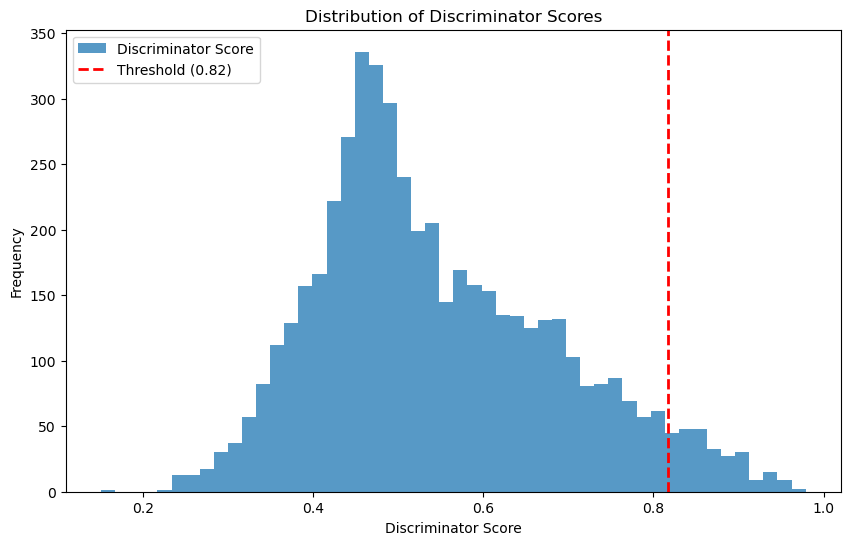

In [8]:
# 8. Dự đoán trên tập kiểm tra bằng Discriminator
with torch.no_grad():
    test_outputs = discriminator(X_test_tensor).numpy().flatten()

# 9. Thiết lập ngưỡng phát hiện bất thường
threshold = np.percentile(test_outputs, 95)
print(f"Ngưỡng phát hiện: {threshold}")

# 10. Dự đoán bất thường
y_pred = (test_outputs < threshold).astype(int)  # Bất thường nếu Discriminator cho điểm thấp

# 11. In Confusion Matrix và Classification Report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 12. Tính ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# 13. Vẽ biểu đồ điểm Discriminator và ngưỡng
plt.figure(figsize=(10, 6))
plt.hist(test_outputs, bins=50, alpha=0.75, label='Discriminator Score')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.xlabel('Discriminator Score')
plt.ylabel('Frequency')
plt.title('Distribution of Discriminator Scores')
plt.legend()
plt.show()